# Install modules

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 15.3 MB/s eta 0:00:00


In [3]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=75e8e9ff67f1c41d4f1fb88194cb32fb571c177d7da036c3c28c46f0f4db9b33
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [4]:
# Import modules
import tensorflow as tf
import tensorflow.keras as K

from tensorflow.keras.applications import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

import numpy as np
import librosa.display, os
import keras.utils as image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow_hub as hub
import datetime
import matplotlib.pyplot as plt

In [5]:
# For XAI
import lime
from skimage.segmentation import mark_boundaries

from tensorflow import keras
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
import requests
from skimage.segmentation import slic
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import shap
import warnings

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    %matplotlib inline
    plt.imshow(mark_boundaries(image, mask))
    plt.plot()

# Load data

In [8]:
!mkdir /content/Spectrogram

In [9]:
!unzip "/content/drive/MyDrive/Spectrograms_training.zip" -d "/content/Spectrogram"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Spectrogram/real/recording8450.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording11067.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording6690.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording11512.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording7481.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording9871.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording10848.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording12330.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording9474.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording12415.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording9204.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording8878.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording11959.png_norm_mono.

In [10]:
# Load data parameters
tf.random.set_seed(42)

batch_size = 32
img_height = img_width = 224
channels = 3
epochs = 20
input_shape = (224, 224, 3)

root = '/content/Spectrogram' #r'path_to_Spectrogram_folder' 

In [11]:
train_ds = K.utils.image_dataset_from_directory(str(root), 
                                               validation_split = 0.2,
                                               subset = 'training',
                                               seed = 42,
                                               image_size = (img_height, img_width),
                                               batch_size = batch_size)

test_ds = K.utils.image_dataset_from_directory(str(root), 
                                               validation_split = 0.2,
                                               subset = 'validation',
                                               seed = 42,
                                               image_size = (img_height, img_width),
                                               batch_size = batch_size)

Found 10208 files belonging to 2 classes.
Using 8167 files for training.
Found 10208 files belonging to 2 classes.
Using 2041 files for validation.


In [12]:
class_names = np.array(train_ds.class_names)
print(class_names)

['fake' 'real']


In [13]:
# 32 (224*224*3) sized images in 1 batch
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [14]:
total_train_samples = len(train_ds)
steps_per_epoch = tf.math.ceil(total_train_samples / batch_size)

In [15]:
total_val_samples = len(test_ds)
validation_steps = tf.math.ceil(total_val_samples / batch_size)

# VGG16

In [16]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
for layer in vgg16.layers:
    layer.trainable = False

In [18]:
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [19]:
model_vgg = Model(inputs=vgg16.input, outputs=x)

In [20]:
model_vgg.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

In [21]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
history_vgg16 = model_vgg.fit(train_ds, epochs=30, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_ds, 
                    validation_steps=validation_steps)

Epoch 1/30
8/8 [==============================] - 19s 564ms/step - loss: 5.3161 - accuracy: 0.4883 - val_loss: 2.9275 - val_accuracy: 0.4062
Epoch 2/30
8/8 [==============================] - 2s 309ms/step - loss: 3.6446 - accuracy: 0.5586 - val_loss: 1.9963 - val_accuracy: 0.6094
Epoch 3/30
8/8 [==============================] - 2s 265ms/step - loss: 4.2492 - accuracy: 0.5430 - val_loss: 1.8374 - val_accuracy: 0.6094
Epoch 4/30
8/8 [==============================] - 2s 310ms/step - loss: 3.6487 - accuracy: 0.5547 - val_loss: 2.0150 - val_accuracy: 0.5938
Epoch 5/30
8/8 [==============================] - 4s 495ms/step - loss: 3.5261 - accuracy: 0.6367 - val_loss: 1.4820 - val_accuracy: 0.6250
Epoch 6/30
8/8 [==============================] - 2s 273ms/step - loss: 3.0478 - accuracy: 0.6562 - val_loss: 1.5638 - val_accuracy: 0.7031
Epoch 7/30
8/8 [==============================] - 2s 257ms/step - loss: 2.5689 - accuracy: 0.6875 - val_loss: 1.9849 - val_accuracy: 0.6875
Epoch 8/30
8/8 [===

In [23]:
loss, accuracy = model_vgg.evaluate(test_ds)
print('Validation accuracy:', accuracy)

64/64 [==============================] - 13s 191ms/step - loss: 0.6004 - accuracy: 0.8373
Validation accuracy: 0.8373346328735352


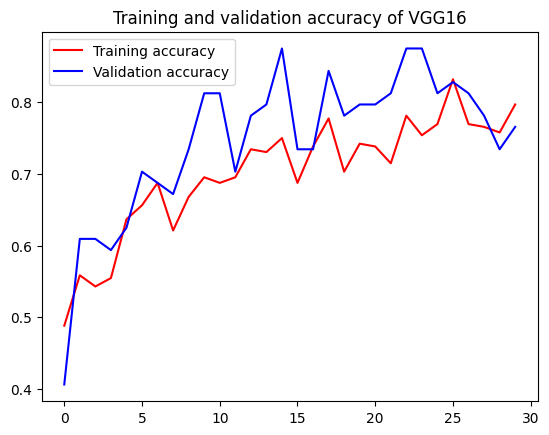

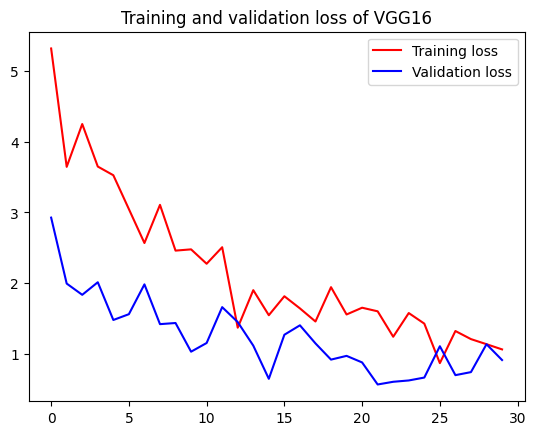

In [24]:
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy of VGG16')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of VGG16')
plt.legend()

plt.show()

In [25]:
predicted_batch = model_vgg.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print('VGG:',predicted_label_batch)

1/1 [==============================] - 0s 187ms/step
VGG: ['fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake']


In [26]:
# Save weights learnt by the model
model_vgg.save_weights('./checkpoints/my_checkpoint1')
model_vgg.save('/content/drive/MyDrive/audio/my_vgg16')

## XAI for VGG16

1. Lime
2. SHAP
3. GradCAM

In [27]:
model_vgg = keras.models.load_model('/content/drive/MyDrive/audio/my_vgg16')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


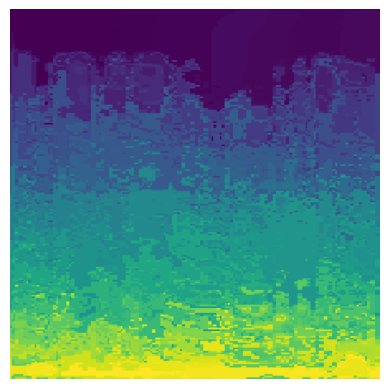

In [28]:
import lime.lime_image

explainer = lime.lime_image.LimeImageExplainer()
exp = explainer.explain_instance(np.array(image_batch[0]).astype('double'),
                                model_vgg.predict,
                                hide_color = 0,
                                num_samples = 1000)
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

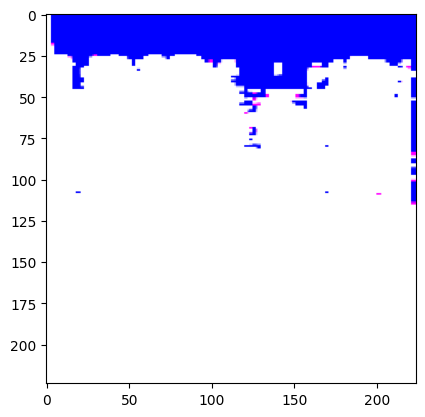

In [29]:
# Features of spectrogram used to identify data
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

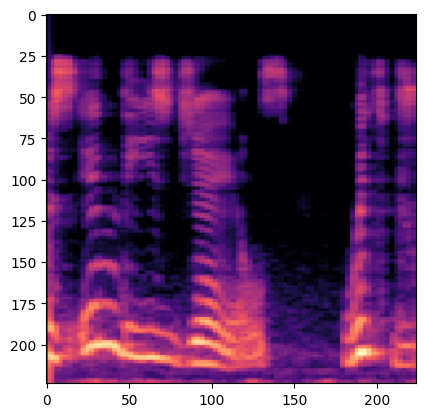

In [30]:
# SHAP
file = r'/content/Spectrogram/real/recording10002.png_norm_mono.png'
img = load_img(file, target_size = (224, 224))
img_orig = img_to_array(img)
plt.imshow(img)
plt.show()

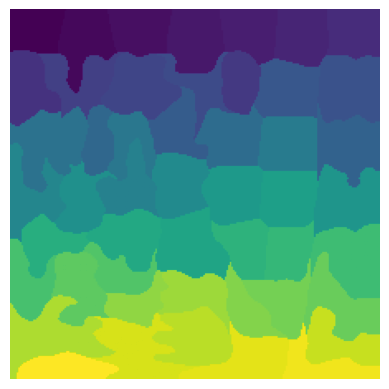

In [31]:
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)
plt.imshow(segments_slic);
plt.axis('off')
plt.show()

In [32]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

def f(z):
    return model_vgg.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [33]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

1/1 [==============================] - 1s 592ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 5s 170ms/step


In [34]:
# get the top predictions from the model
preds = model_vgg.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)
top_preds

1/1 [==============================] - 0s 20ms/step


array([[0]])

In [35]:
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
    
cm = LinearSegmentedColormap.from_list("shap", colors)
# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

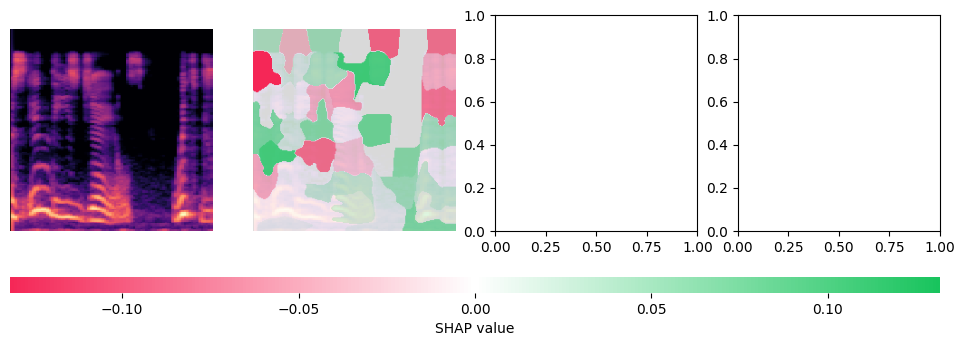

In [36]:
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')

max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(1):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].imshow(img, alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

1/1 [==============================] - 0s 21ms/step


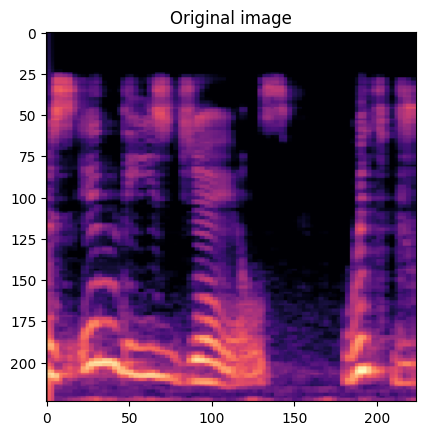

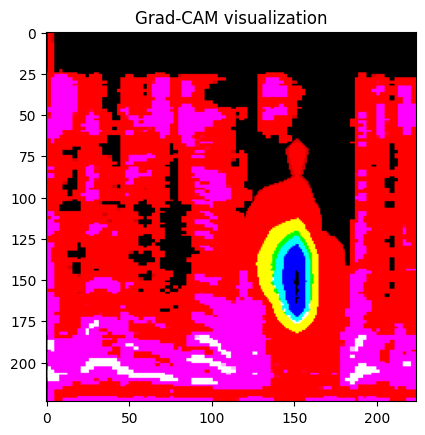

In [37]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load pre-trained VGG16 model
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

# Get the output tensor of the last convolutional layer
last_conv_layer = model.get_layer('block5_conv3')

# Create a new model that outputs the last convolutional layer activations and the final output predictions
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

# Get the image you want to visualize
img = tf.keras.preprocessing.image.load_img(file, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img) # convert to numpy array
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)

# Get the predicted class index
preds = model_vgg.predict(x)
class_idx = np.argmax(preds[0])

# Compute the gradient of the class output value with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(x)
    class_output = preds[:, class_idx]
grads = tape.gradient(class_output, last_conv_layer_output)

# Compute the channel-wise mean of the gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each activation map with its corresponding gradient
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# Resize the heatmap to be the same size as the original image
heatmap = cv2.resize(np.float32(heatmap), (x.shape[2], x.shape[1]))

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert heatmap to same datatype as input image
heatmap = heatmap.astype(np.float32)

# Overlay the heatmap on top of the original image
superimposed_img = cv2.addWeighted(x[0], 0.6, heatmap, 0.4, 0)

# Display the results
plt.imshow(img)
plt.title('Original image')
plt.show()

plt.imshow(superimposed_img)
plt.title('Grad-CAM visualization')
plt.show()

# Custom CNN

In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_cnn.add(MaxPooling2D(2, 2))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))

model_cnn.add(Flatten())

model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(0.3))

model_cnn.add(Dense(512, activation = 'relu'))
model_cnn.add(tf.keras.layers.Dropout(0.3))

model_cnn.add(Dense(1, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

log_dir = "logs/fit/" + "cnn-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1)

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
history4 = model_cnn.fit(train_ds,
                    validation_data = test_ds,
                    epochs = 20,
                    callbacks = tensorboard_callback)

Epoch 1/20
256/256 [==============================] - ETA: 0s - loss: 6.1121 - accuracy: 0.4972

In [1]:
# Check predictions
predicted_batch = model_cnn.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print('Custom CNN', predicted_label_batch)

NameError: ignored

In [ ]:
# Plot accuracy curve
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of Custom CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot loss curve
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss of Custom CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save weights learnt by the model
model.save_weights('./checkpoints/my_checkpoint1')
model.save('/content/drive/MyDrive/audio/my_cnn')

## XAI for custom CNN

1. Lime
2. SHAP
3. GradCAM

In [ ]:
model_cnn = keras.models.load_model('/content/drive/MyDrive/audio/my_cnn')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


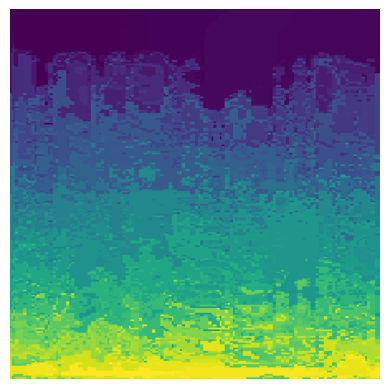

In [ ]:
import lime.lime_image

explainer = lime.lime_image.LimeImageExplainer()
exp = explainer.explain_instance(np.array(image_batch[0]).astype('double'),
                                model_cnn.predict,
                                hide_color = 0,
                                num_samples = 1000)
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

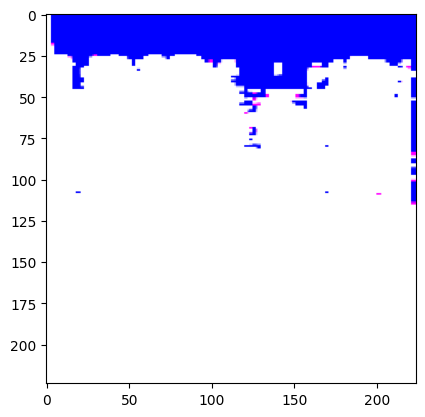

In [ ]:
# Features of spectrogram used to identify data
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

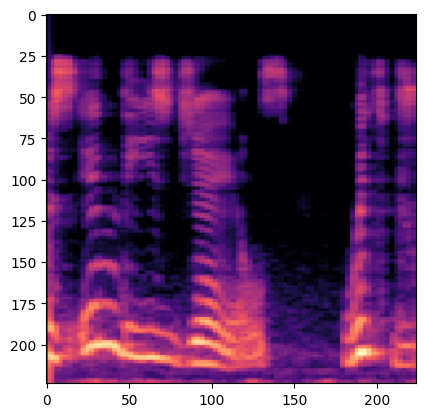

In [ ]:
# SHAP
file = r'/content/Spectrogram/real/recording10002.png_norm_mono.png'
img = load_img(file, target_size = (224, 224))
img_orig = img_to_array(img)
plt.imshow(img)
plt.show()

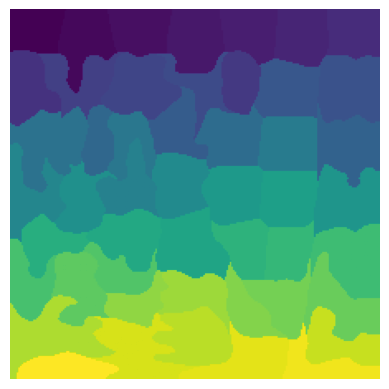

In [ ]:
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)
plt.imshow(segments_slic);
plt.axis('off')
plt.show()

In [ ]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

def f(z):
    return model_cnn.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [ ]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

1/1 [==============================] - 1s 572ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 5s 165ms/step


In [ ]:
# get the top predictions from the model
preds = model_cnn.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)
top_preds

1/1 [==============================] - 0s 21ms/step


array([[0]])

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
    
cm = LinearSegmentedColormap.from_list("shap", colors)
# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

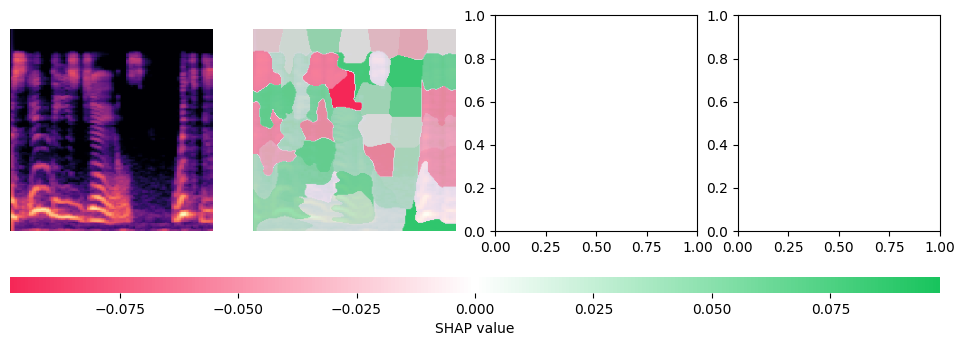

In [ ]:
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')

max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(1):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].imshow(img, alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

1/1 [==============================] - 0s 24ms/step


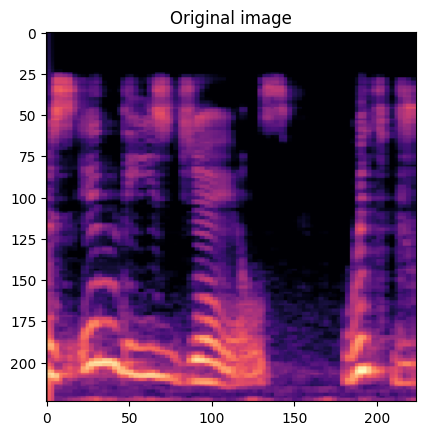

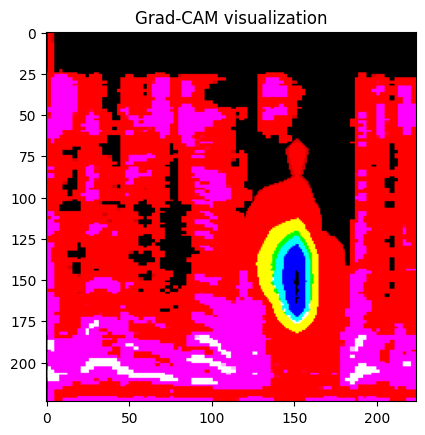

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load pre-trained VGG16 model
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

# Get the output tensor of the last convolutional layer
last_conv_layer = model.get_layer('block5_conv3')

# Create a new model that outputs the last convolutional layer activations and the final output predictions
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

# Get the image you want to visualize
img = tf.keras.preprocessing.image.load_img(file, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img) # convert to numpy array
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)

# Get the predicted class index
preds = model_cnn.predict(x)
class_idx = np.argmax(preds[0])

# Compute the gradient of the class output value with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(x)
    class_output = preds[:, class_idx]
grads = tape.gradient(class_output, last_conv_layer_output)

# Compute the channel-wise mean of the gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each activation map with its corresponding gradient
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# Resize the heatmap to be the same size as the original image
heatmap = cv2.resize(np.float32(heatmap), (x.shape[2], x.shape[1]))

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert heatmap to same datatype as input image
heatmap = heatmap.astype(np.float32)

# Overlay the heatmap on top of the original image
superimposed_img = cv2.addWeighted(x[0], 0.6, heatmap, 0.4, 0)

# Display the results
plt.imshow(img)
plt.title('Original image')
plt.show()

plt.imshow(superimposed_img)
plt.title('Grad-CAM visualization')
plt.show()

## WARNING: RAM crash due to high memory requirment.

ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height, img_width, channels))

# Do not train the model, leverage pretrained layers
for layer in resnet.layers:
    layer.trainable = False
    
resnet.summary()

94765736/94765736 [==============================] - 6s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
# Create transfer learning model

model_resnet = Sequential()

# Add pretrained model as it is
model_resnet.add(resnet)
# Flatten last layer of resnet
model_resnet.add(Flatten())
# Add layers of our own
model_resnet.add(Dense(512, activation='relu', input_dim=(img_height, img_width, channels)))
model_resnet.add(tf.keras.layers.Dropout(0.3))
model_resnet.add(Dense(512, activation='relu'))
model_resnet.add(tf.keras.layers.Dropout(0.3))
model_resnet.add(Dense(1, activation='sigmoid'))

model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 5

In [ ]:
model_resnet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.RMSprop(learning_rate = 2e-5), 
                     metrics=['accuracy'])

log_dir = "logs/fit/" + "resnet-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1)

In [ ]:
history3 = model_resnet.fit(train_ds,
                    validation_data = test_ds,
                    epochs = 20,
                    callbacks = tensorboard_callback)

Epoch 1/20
256/256 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8083

In [ ]:
# Check predictions
predicted_batch = model_resnet.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print('ResNet50:',predicted_label_batch)

In [ ]:
# Plot accuracy curve
acc = history3.history['acc']
val_acc = history3.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot loss curve
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss of ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save weights learnt by the model
model.save_weights('./checkpoints/my_checkpoint1')
model.save('/content/drive/MyDrive/audio/my_resnet')

## XAI for ResNet50
1. Lime
2. SHAP
3. GradCAM

In [ ]:
model_resnet = keras.models.load_model('/content/drive/MyDrive/audio/my_resnet')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


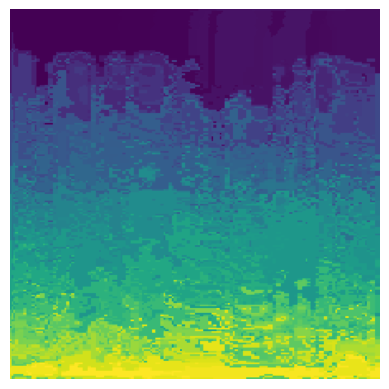

In [ ]:
import lime.lime_image

explainer = lime.lime_image.LimeImageExplainer()
exp = explainer.explain_instance(np.array(image_batch[0]),
                                model_resnet.predict,
                                hide_color = 0,
                                num_samples = 1000)
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

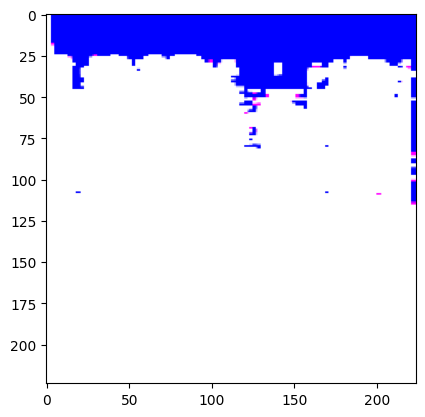

In [ ]:
# Features of spectrogram used to identify data as real -> 0
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

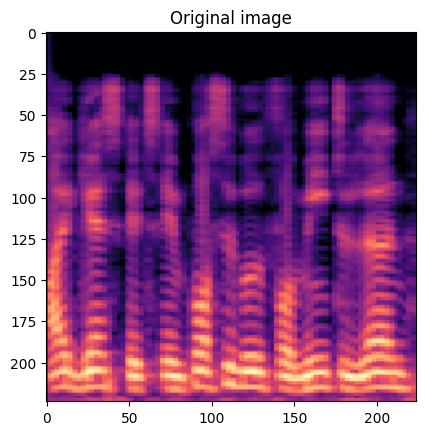

In [ ]:
file = r'/content/Spectrogram/fake/recording1002.png_norm_mono.png'
img = load_img(file, target_size = (224, 224))
img_orig = img_to_array(img)
plt.title('Original image')
plt.imshow(img)
plt.show()

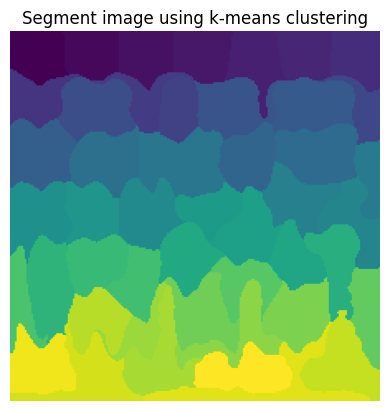

In [ ]:
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)
plt.imshow(segments_slic);
plt.title('Segment image using k-means clustering')
plt.axis('off')
plt.show()

In [ ]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

def f(z):
    return model_resnet.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [ ]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

1/1 [==============================] - 1s 751ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 2s 77ms/step


In [ ]:
# get the top predictions from the model
preds = model_resnet.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)
top_preds

1/1 [==============================] - 1s 752ms/step


array([[0]])

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
    
cm = LinearSegmentedColormap.from_list("shap", colors)
# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

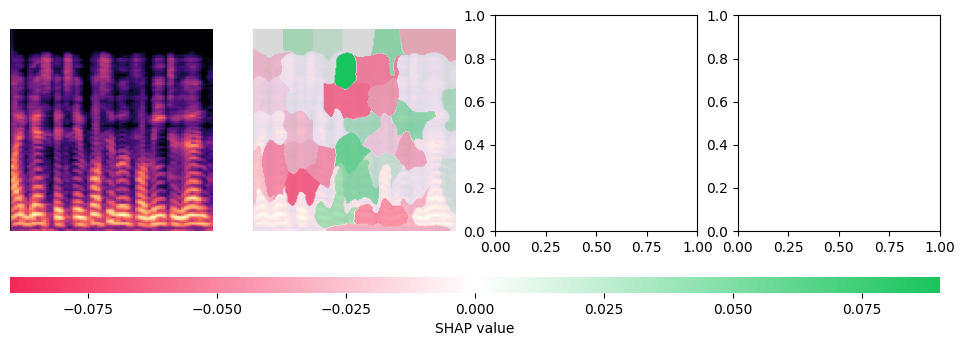

In [ ]:
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')

max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(1):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].imshow(img, alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

1/1 [==============================] - 0s 48ms/step


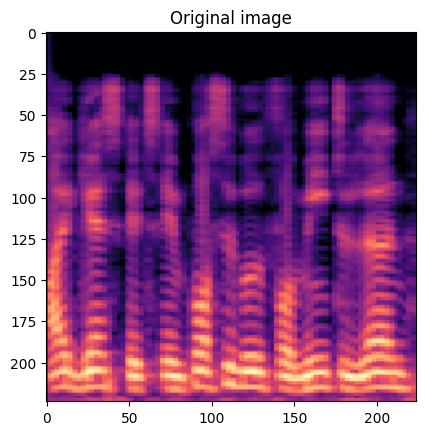

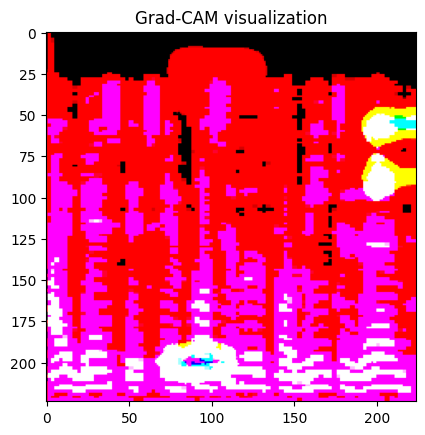

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load pre-trained VGG16 model
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

# Get the output tensor of the last convolutional layer
last_conv_layer = model.get_layer('block5_conv3')

# Create a new model that outputs the last convolutional layer activations and the final output predictions
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

# Get the image you want to visualize
img = tf.keras.preprocessing.image.load_img(file, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img) # convert to numpy array
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)

# Get the predicted class index
preds = model_resnet.predict(x)
class_idx = np.argmax(preds[0])

# Compute the gradient of the class output value with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(x)
    class_output = preds[:, class_idx]
grads = tape.gradient(class_output, last_conv_layer_output)

# Compute the channel-wise mean of the gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each activation map with its corresponding gradient
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# Resize the heatmap to be the same size as the original image
heatmap = cv2.resize(np.float32(heatmap), (x.shape[2], x.shape[1]))

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert heatmap to same datatype as input image
heatmap = heatmap.astype(np.float32)

# Overlay the heatmap on top of the original image
superimposed_img = cv2.addWeighted(x[0], 0.6, heatmap, 0.4, 0)

# Display the results
plt.imshow(img)
plt.title('Original image')
plt.show()

plt.imshow(superimposed_img)
plt.title('Grad-CAM visualization')
plt.show()